### Part 1: Setup and Data Loading

In [1]:
import pandas as pd
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from pathlib import Path

# Create a directory to save figures
figures_dir = Path('../figures')
figures_dir.mkdir(parents=True, exist_ok=True)

c:\Users\53575\anaconda3\envs\aipi510\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# Load our existing clean Field of Study (FoS) data
fos_path = Path('../data/processed/field_of_study_processed.csv')
if fos_path.exists():
    print(f"Loading existing processed data from: {fos_path}")
    df_fos = pd.read_csv(fos_path)
    print("Field of Study data loaded successfully.")
else:
    print(f"ERROR: Processed data file not found at {fos_path}")
    print("Please run notebook1 first to generate this file.")
    df_fos = None

Loading existing processed data from: ..\data\processed\field_of_study_processed.csv
Field of Study data loaded successfully.


In [3]:
# Download another dataset from Google Drive if not already present
# 1. Setup file path and download link
data_dir = Path('../data/raw')      # Directory to store raw data
file_path = data_dir / 'Most-Recent-Cohorts-Institution.csv'   # Define the final data file name and path
drive_link = "https://drive.google.com/file/d/1EhS5gZPAqkQI23SJBPRN9ixaniogTnR8/view?usp=sharing"     # Google Drive link to download the data

# 2. Check if file exists, download if it doesn't
data_dir.mkdir(parents=True, exist_ok=True)     # Make sure the data directory exists, create it if not

if not file_path.exists():
    print(f"File not found at '{file_path}', starting download from Google Drive...")
    gdown.download(drive_link, str(file_path), fuzzy=True)
    print("Download complete!")
else:
    print(f"File already exists at '{file_path}', skipping download.")

# 3. Load the CSV data into a DataFrame
df_raw = pd.read_csv(file_path, low_memory=False)     
print("Data loaded successfully!")


File not found at '..\data\raw\Most-Recent-Cohorts-Institution.csv', starting download from Google Drive...


Downloading...
From: https://drive.google.com/uc?id=1EhS5gZPAqkQI23SJBPRN9ixaniogTnR8
To: c:\Users\53575\OneDrive\桌面\2025 Fall\AIPI 510\AIPI 510_code\college-scorecard-roi-storytelling\data\raw\Most-Recent-Cohorts-Institution.csv
100%|██████████| 103M/103M [00:02<00:00, 38.7MB/s] 


Download complete!
Data loaded successfully!


### Part 2: Preprocess Institution Data and Merge

2.1 Attain the Dataset

In [4]:
# 2.1: Add a Reliable Join Key (OPEID6) to the FoS Data

# First, let's enhance our clean FoS dataframe by adding the 'OPEID6' unique ID.
# This is more reliable for merging than using the institution name.

# We'll quickly load the raw FoS data again just to grab the IDs.
raw_fos_path = Path('../data/raw/Most-Recent-Cohorts-Field-of-Study.csv') 
df_raw_fos_temp = pd.read_csv(raw_fos_path, usecols=['INSTNM', 'OPEID6'])

# Remove duplicates to create a clean mapping between name and ID.
df_id_map = df_raw_fos_temp.drop_duplicates(subset=['INSTNM']).dropna()

# Now, merge this ID into our clean df_fos.
df_fos_enhanced = pd.merge(
    df_fos,
    df_id_map,
    on='INSTNM',
    how='left'
)

# We drop rows where the ID could not be found
df_fos_enhanced.dropna(subset=['OPEID6'], inplace=True)
# Convert OPEID6 to integer for a clean merge
df_fos_enhanced['OPEID6'] = df_fos_enhanced['OPEID6'].astype(int)

print("Successfully added 'OPEID6' to the Field of Study data.")
print(f"Enhanced FoS data shape: {df_fos_enhanced.shape}")
display(df_fos_enhanced.head())

Successfully added 'OPEID6' to the Field of Study data.
Enhanced FoS data shape: (26905, 22)


,EARN_MDN_5YR,DEBT_ALL_STGP_ANY_MDN,DEBT_ALL_STGP_EVAL_MDN,DEBT_ALL_STGP_ANY_MDN10YRPAY,DEBT_ALL_STGP_EVAL_MDN10YRPAY,INSTNM,CIPCODE,CIPDESC,CREDLEV,CREDDESC,...,ROI_EARNINGS_TO_DEBT,DEBT_TO_INCOME_RATIO,PAYBACK_YEARS,MONTHLY_PAYMENT_PCT,CREDENTIAL_LEVEL_NAME,CIP_2DIGIT,MAJOR_FIELD,ROI_CATEGORY,AFFORDABILITY,OPEID6
0,85218.0,31000.0,30100.0,329.0,319.0,Alabama A & M University,1101,"Computer and Information Sciences, General.",3,Bachelor's Degree,...,2.748968,0.363773,0.363773,4.632824,Bachelor Degree,11,Computer Science,Good (2.5-4),Very Affordable (<8%),1002
1,90409.0,35000.0,32500.0,371.0,345.0,Alabama A & M University,1410,"Electrical, Electronics and Communications Eng...",3,Bachelor's Degree,...,2.583114,0.387130,0.387130,4.924289,Bachelor Degree,14,Engineering,Good (2.5-4),Very Affordable (<8%),1002
2,82929.0,30500.0,27100.0,323.0,287.0,Alabama A & M University,1419,Mechanical Engineering.,3,Bachelor's Degree,...,2.718984,0.367784,0.367784,4.673878,Bachelor Degree,14,Engineering,Good (2.5-4),Very Affordable (<8%),1002
3,46627.0,33000.0,31000.0,350.0,329.0,Alabama A & M University,2401,"Liberal Arts and Sciences, General Studies and...",3,Bachelor's Degree,...,1.412939,0.707744,0.707744,9.007657,Bachelor Degree,24,Liberal Arts & Humanities,Low (1-1.5),Affordable (8-12%),1002
4,40721.0,28271.0,27011.0,300.0,286.0,Alabama A & M University,2601,"Biology, General.",3,Bachelor's Degree,...,1.440381,0.694261,0.694261,8.840647,Bachelor Degree,26,Biological Sciences,Low (1-1.5),Affordable (8-12%),1002


In [5]:
# 2.2: Select, Clean, and Merge Institution Data using the Key

# 1. Now we select columns from the raw institution data, using OPEID6 as our key.
cols_to_select = [
    'OPEID6',          # The unique ID for merging
    'TUITIONFEE_IN',   # In-state tuition and fees
    'UGDS_WOMEN'       # Proportion of undergraduate students who are women
]

print(f"Columns selected for merging: {cols_to_select}")
df_inst_clean = df_raw[cols_to_select].copy()

# 2. Clean the selected columns.
df_inst_clean['TUITIONFEE_IN'] = pd.to_numeric(df_inst_clean['TUITIONFEE_IN'], errors='coerce')
df_inst_clean['UGDS_WOMEN'] = pd.to_numeric(df_inst_clean['UGDS_WOMEN'], errors='coerce')

# Drop rows where the ID is missing and remove duplicates.
df_inst_clean.dropna(subset=['OPEID6'], inplace=True)
df_inst_clean['OPEID6'] = df_inst_clean['OPEID6'].astype(int)
df_inst_clean.drop_duplicates(subset=['OPEID6'], keep='first', inplace=True)

print(f"\nCleaned institution data has {df_inst_clean.shape[0]} unique schools.")

# 3. Merge the two dataframes using our reliable 'OPEID6' key.
print("\nMerging the two dataframes on 'OPEID6'...")
df_merged = pd.merge(
    df_fos_enhanced,
    df_inst_clean,
    on='OPEID6',
    how='left'
)

print("Merge complete!")
print(f"Shape of the new merged dataframe: {df_merged.shape}")

# 4. Final verification.
tuition_non_null = df_merged['TUITIONFEE_IN'].notna().sum()
total_rows = len(df_merged)
print(f"\nSuccessfully matched tuition data for {tuition_non_null} out of {total_rows} programs ({ (tuition_non_null/total_rows*100):.2f}%).")

print("\n--- Preview of the Final Merged Data ---")
display(df_merged.head())

Columns selected for merging: ['OPEID6', 'TUITIONFEE_IN', 'UGDS_WOMEN']

Cleaned institution data has 5071 unique schools.

Merging the two dataframes on 'OPEID6'...
Merge complete!
Shape of the new merged dataframe: (26905, 24)

Successfully matched tuition data for 23924 out of 26905 programs (88.92%).

--- Preview of the Final Merged Data ---


,EARN_MDN_5YR,DEBT_ALL_STGP_ANY_MDN,DEBT_ALL_STGP_EVAL_MDN,DEBT_ALL_STGP_ANY_MDN10YRPAY,DEBT_ALL_STGP_EVAL_MDN10YRPAY,INSTNM,CIPCODE,CIPDESC,CREDLEV,CREDDESC,...,PAYBACK_YEARS,MONTHLY_PAYMENT_PCT,CREDENTIAL_LEVEL_NAME,CIP_2DIGIT,MAJOR_FIELD,ROI_CATEGORY,AFFORDABILITY,OPEID6,TUITIONFEE_IN,UGDS_WOMEN
0,85218.0,31000.0,30100.0,329.0,319.0,Alabama A & M University,1101,"Computer and Information Sciences, General.",3,Bachelor's Degree,...,0.363773,4.632824,Bachelor Degree,11,Computer Science,Good (2.5-4),Very Affordable (<8%),1002,10024.0,0.5828
1,90409.0,35000.0,32500.0,371.0,345.0,Alabama A & M University,1410,"Electrical, Electronics and Communications Eng...",3,Bachelor's Degree,...,0.387130,4.924289,Bachelor Degree,14,Engineering,Good (2.5-4),Very Affordable (<8%),1002,10024.0,0.5828
2,82929.0,30500.0,27100.0,323.0,287.0,Alabama A & M University,1419,Mechanical Engineering.,3,Bachelor's Degree,...,0.367784,4.673878,Bachelor Degree,14,Engineering,Good (2.5-4),Very Affordable (<8%),1002,10024.0,0.5828
3,46627.0,33000.0,31000.0,350.0,329.0,Alabama A & M University,2401,"Liberal Arts and Sciences, General Studies and...",3,Bachelor's Degree,...,0.707744,9.007657,Bachelor Degree,24,Liberal Arts & Humanities,Low (1-1.5),Affordable (8-12%),1002,10024.0,0.5828
4,40721.0,28271.0,27011.0,300.0,286.0,Alabama A & M University,2601,"Biology, General.",3,Bachelor's Degree,...,0.694261,8.840647,Bachelor Degree,26,Biological Sciences,Low (1-1.5),Affordable (8-12%),1002,10024.0,0.5828


2.2 Understanding Our Merged Dataset

In [6]:
print(f"The table has {df_merged.shape[0]} rows, each representing a unique academic program.")

# For clarity, let's display only a few key columns.
columns_to_inspect = [
    'INSTNM',     # Institution Name (from institution data)
    'CIPDESC',    # Field of Study Description (from FoS data)
    'ROI_EARNINGS_TO_DEBT',   # ROI (from our FoS data calculations)
    'TUITIONFEE_IN',    # Tuition (from institution data)
    'UGDS_WOMEN',      # Proportion of female students (from institution data)
    'CONTROL'     # Institution Type (from institution data)
]

display(df_merged[columns_to_inspect].head())

The table has 26905 rows, each representing a unique academic program.


,INSTNM,CIPDESC,ROI_EARNINGS_TO_DEBT,TUITIONFEE_IN,UGDS_WOMEN,CONTROL
0,Alabama A & M University,"Computer and Information Sciences, General.",2.748968,10024.0,0.5828,Public
1,Alabama A & M University,"Electrical, Electronics and Communications Eng...",2.583114,10024.0,0.5828,Public
2,Alabama A & M University,Mechanical Engineering.,2.718984,10024.0,0.5828,Public
3,Alabama A & M University,"Liberal Arts and Sciences, General Studies and...",1.412939,10024.0,0.5828,Public
4,Alabama A & M University,"Biology, General.",1.440381,10024.0,0.5828,Public


In [7]:
print("1. Overall Structure")
print(f"Our final dataset has {df_merged.shape[0]} rows (programs) and {df_merged.shape[1]} columns (facts).")
print("There are NO missing values in the key columns we will use for analysis.")
print("\n")


print("2. How many programs from each type of school?")
control_counts = df_merged['CONTROL'].value_counts()
print(control_counts)
print("\n")


print("3. A description of Our Key Numerical Data")
columns_to_describe = ['ROI_EARNINGS_TO_DEBT', 'TUITIONFEE_IN', 'UGDS_WOMEN']
description = df_merged[columns_to_describe].describe()
display(description)


print("\n4. Let's Look at a Sample 'Program Fact Sheet'")
columns_to_inspect = [
    'INSTNM',
    'CIPDESC',
    'CONTROL',            
    'ROI_EARNINGS_TO_DEBT', 
    'TUITIONFEE_IN',      
    'UGDS_WOMEN'         
]
display(df_merged[columns_to_inspect].sample(n=10))

1. Overall Structure
Our final dataset has 26905 rows (programs) and 24 columns (facts).
There are NO missing values in the key columns we will use for analysis.


2. How many programs from each type of school?
CONTROL
Public                 16471
Private, nonprofit      6870
Private, for-profit     3564
Name: count, dtype: int64


3. A description of Our Key Numerical Data


,ROI_EARNINGS_TO_DEBT,TUITIONFEE_IN,UGDS_WOMEN
count,26905.000000,23924.000000,26645.000000
mean,3.062924,18414.036031,0.587936
std,1.623240,16988.711558,0.140699
min,0.573020,1104.000000,0.000000
25%,2.012235,7278.000000,0.530400
50%,2.702121,11389.000000,0.577900
75%,3.648000,21501.000000,0.631900
max,32.233091,69330.000000,1.000000



4. Let's Look at a Sample 'Program Fact Sheet'


,INSTNM,CIPDESC,CONTROL,ROI_EARNINGS_TO_DEBT,TUITIONFEE_IN,UGDS_WOMEN
4143,Saint Leo University,"Business Administration, Management and Operat...","Private, nonprofit",1.417551,28360.0,0.5901
25452,Miller-Motte College-Raleigh,Allied Health and Medical Assisting Services.,"Private, for-profit",1.534788,NaN,0.1462
21224,Norwich University,Construction Management.,"Private, nonprofit",3.016728,49600.0,0.2811
10555,St Cloud Technical and Community College,"Liberal Arts and Sciences, General Studies and...",Public,3.190722,4957.0,0.6122
1826,CET-San Jose,Allied Health and Medical Assisting Services.,"Private, nonprofit",5.076593,NaN,0.1111
20942,Wharton County Junior College,"Registered Nursing, Nursing Administration, Nu...",Public,5.986138,2916.0,0.5718
19030,Austin Peay State University,Clinical/Medical Laboratory Science/Research a...,Public,3.306357,8675.0,0.5891
13622,Monroe Community College,Vehicle Maintenance and Repair Technologies.,Public,5.240360,5856.0,0.5867
26349,University of Phoenix-Arizona,Health and Medical Administrative Services.,"Private, for-profit",3.122804,NaN,0.3000
24973,Delta Technical College-Mississippi,Allied Health and Medical Assisting Services.,"Private, for-profit",3.099053,NaN,0.5638


5. Visualizing the Distributions of Key Numerical Data


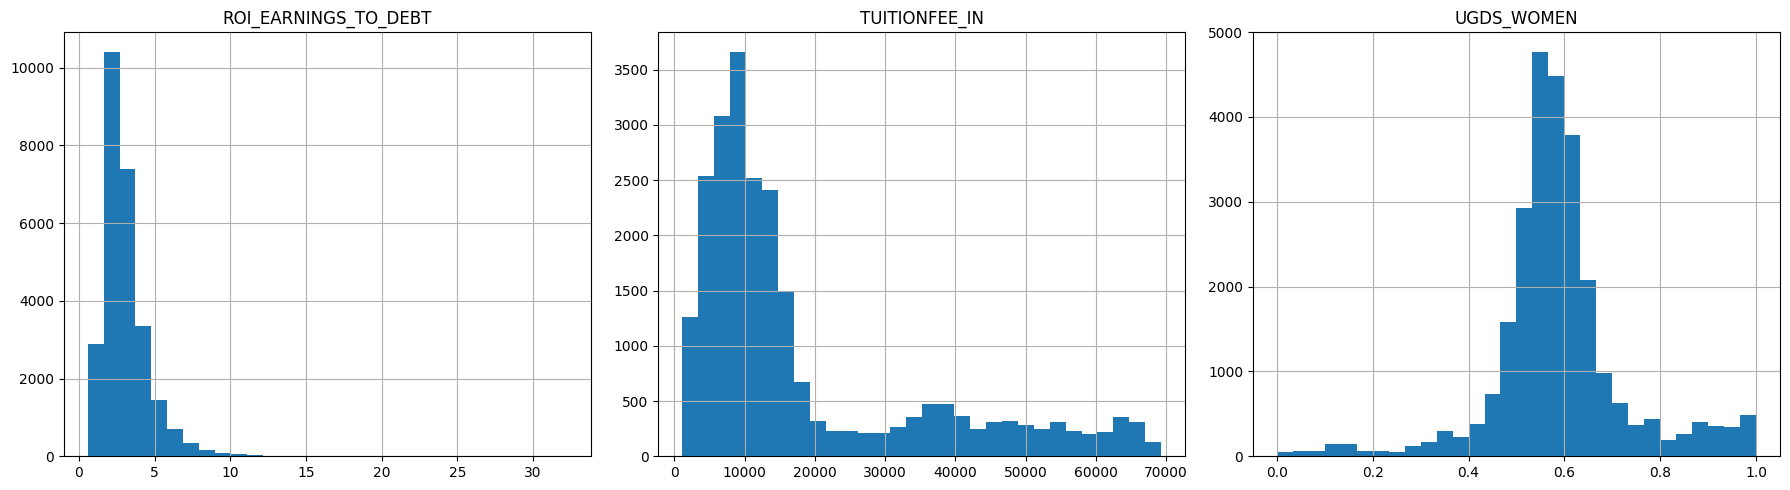

In [8]:
print("5. Visualizing the Distributions of Key Numerical Data")
df_merged[columns_to_describe].hist(bins=30, figsize=(18, 5), layout=(1, 3))
plt.tight_layout() # Adjust layout to prevent plots from overlapping.
figure_path = figures_dir / 'notebook3' / 'distribution_of_key_numeric_data.png'
plt.savefig(figure_path, bbox_inches='tight')
plt.show()

### Part 3: Analysis - Does Higher Tuition Mean Higher ROI?

Goal: We will now test the common assumption that more expensive schools provide a better return on investment. A scatter plot is the perfect tool to visualize the relationship between two continuous variables like tuition and ROI.

3.1 Visualize the Relationship Between Tuition and ROI by Institution Types.

In [9]:
# Data Preparation for Plotting
# We need to work with complete data, so let's drop rows that are missing tuition or ROI.
plot_data = df_merged.dropna(subset=['TUITIONFEE_IN', 'ROI_EARNINGS_TO_DEBT']).copy()

# Filter out programs with $0 tuition (e.g., service academies) as they are special cases.
plot_data = plot_data[plot_data['TUITIONFEE_IN'] > 0]

print(f"Analyzing {len(plot_data)} programs with complete tuition and ROI data.")

Analyzing 23924 programs with complete tuition and ROI data.


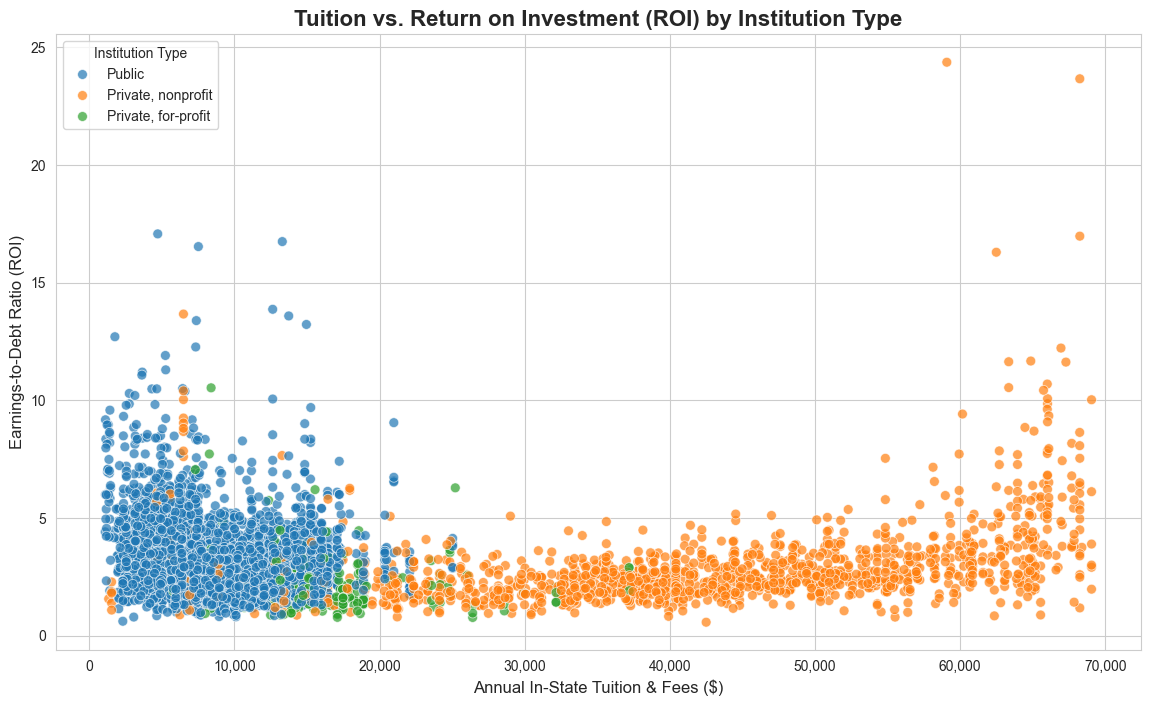


Correlation between In-State Tuition and ROI: -0.0374


In [10]:
# Visualization: Scatter Plot
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))

# Create the scatter plot using seaborn.
# We'll plot a random sample of 5000 points to keep the plot readable and avoid a giant blob of dots.
sns.scatterplot(
    data=plot_data.sample(n=5000, random_state=42),
    x='TUITIONFEE_IN',
    y='ROI_EARNINGS_TO_DEBT',
    hue='CONTROL',      # Color the dots by institution type (Public, Private, etc.)
    alpha=0.7,          # Make the dots slightly transparent to see overlaps.
    s=50                # Adjust the size of the dots.
)

# Add informative titles and labels.
plt.title('Tuition vs. Return on Investment (ROI) by Institution Type', fontsize=16, weight='bold')
plt.xlabel('Annual In-State Tuition & Fees ($)', fontsize=12)
plt.ylabel('Earnings-to-Debt Ratio (ROI)', fontsize=12)
plt.legend(title='Institution Type')

# Format the x-axis to show dollar values clearly.
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

figure_path = figures_dir / 'notebook3' / 'tuition_roi.png'
plt.savefig(figure_path, bbox_inches='tight')
plt.show()


# Quantitative Analysis: Correlation
# Let's calculate the actual correlation coefficient to get a number for this relationship.
correlation = plot_data['TUITIONFEE_IN'].corr(plot_data['ROI_EARNINGS_TO_DEBT'])
print(f"\nCorrelation between In-State Tuition and ROI: {correlation:.4f}")

3.2 Compare Absolute Earnings and Tuitions by Institution Type

In [11]:
# Data Preparation for Plotting
# We need to work with complete data, so let's drop rows that are missing tuition or ROI.
earnings_plot_data = df_merged.dropna(subset=['TUITIONFEE_IN', 'EARN_MDN_5YR']).copy()

# Filter out programs with $0 tuition (e.g., service academies) as they are special cases.
earnings_plot_data = earnings_plot_data[earnings_plot_data['TUITIONFEE_IN'] > 0]

print(f"Analyzing {len(earnings_plot_data)} programs with complete tuition and ROI data.")

Analyzing 23924 programs with complete tuition and ROI data.


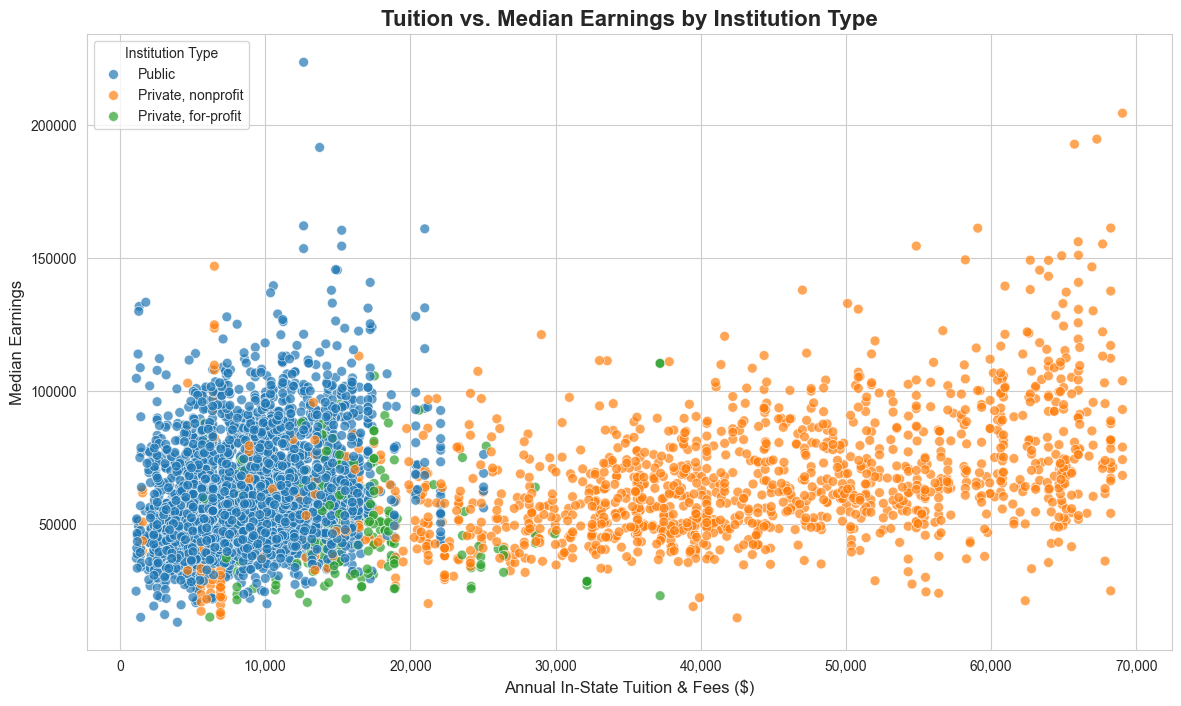


Correlation between In-State Tuition and Medium Earnings: 0.2725


In [12]:
# Visualization: Scatter Plot
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))

# Create the scatter plot using seaborn.
# We'll plot a random sample of 5000 points to keep the plot readable and avoid a giant blob of dots.
sns.scatterplot(
    data=earnings_plot_data.sample(n=5000, random_state=42),
    x='TUITIONFEE_IN',
    y='EARN_MDN_5YR',
    hue='CONTROL',      # Color the dots by institution type (Public, Private, etc.)
    alpha=0.7,          # Make the dots slightly transparent to see overlaps.
    s=50                # Adjust the size of the dots.
)

# Add informative titles and labels.
plt.title('Tuition vs. Median Earnings by Institution Type', fontsize=16, weight='bold')
plt.xlabel('Annual In-State Tuition & Fees ($)', fontsize=12)
plt.ylabel('Median Earnings', fontsize=12)
plt.legend(title='Institution Type')

# Format the x-axis to show dollar values clearly.
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

figure_path = figures_dir / 'notebook3' / 'tuition_earnings.png'
plt.savefig(figure_path, bbox_inches='tight')
plt.show()


# Quantitative Analysis: Correlation
# Let's calculate the actual correlation coefficient to get a number for this relationship.
correlation = earnings_plot_data['TUITIONFEE_IN'].corr(earnings_plot_data['EARN_MDN_5YR'])
print(f"\nCorrelation between In-State Tuition and Medium Earnings: {correlation:.4f}")

3.3 Compare Absolute Earnings by Institution Type

Median Earnings by Institution Type:
CONTROL
Private, nonprofit     61012.0
Public                 55220.0
Private, for-profit    33685.5
Name: EARN_MDN_5YR, dtype: float64


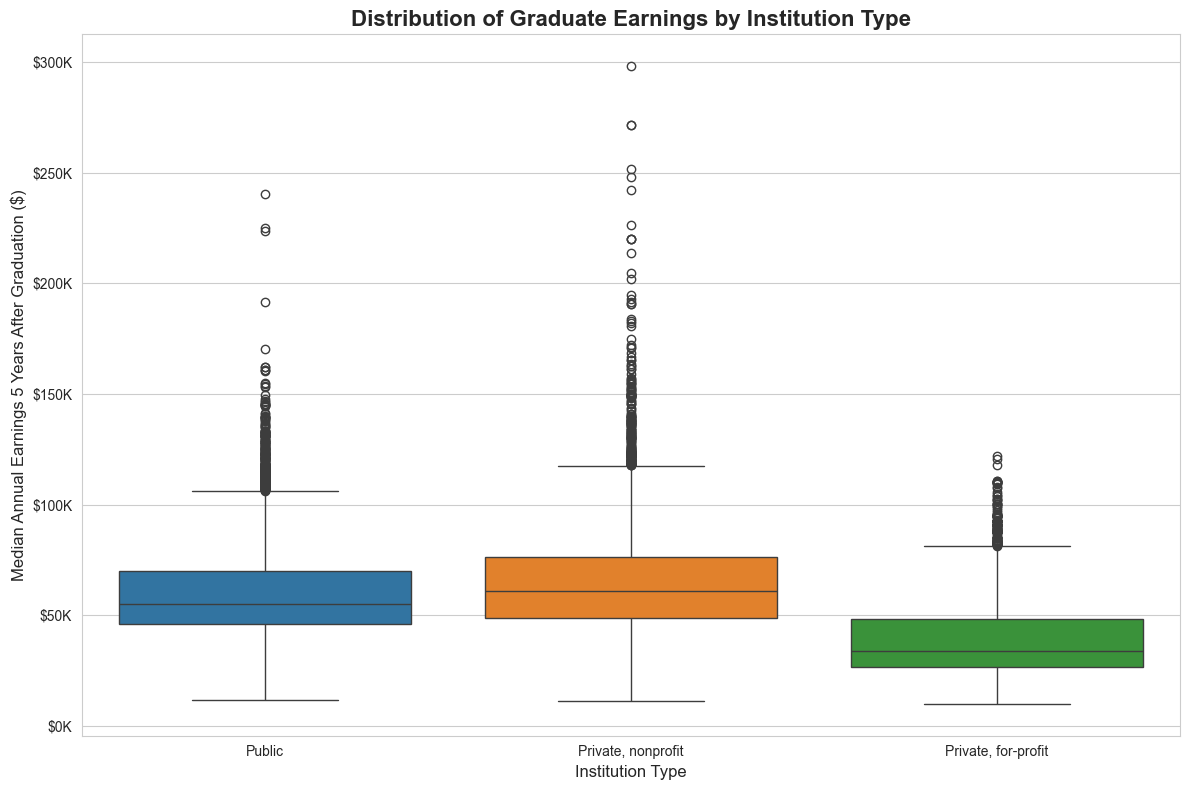

In [13]:
# We select from the main df_merged, keeping only rows where 'CONTROL' and 'EARN_MDN_5YR' are present.
box_plot_data = df_merged.dropna(subset=['CONTROL', 'EARN_MDN_5YR'])

# Calculate precise median earnings by institution type
median_earnings = box_plot_data.groupby('CONTROL')['EARN_MDN_5YR'].median().sort_values(ascending=False)
print("Median Earnings by Institution Type:")
print(median_earnings)



order = ['Public', 'Private, nonprofit', 'Private, for-profit']

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.boxplot(
    data=box_plot_data,
    x='CONTROL',
    hue='CONTROL',
    y='EARN_MDN_5YR',
    order=order
)

plt.title('Distribution of Graduate Earnings by Institution Type', fontsize=16, weight='bold')
plt.xlabel('Institution Type', fontsize=12)
plt.ylabel('Median Annual Earnings 5 Years After Graduation ($)', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'${int(y/1000):,}K'))
plt.xticks(rotation=0)
plt.tight_layout()

figure_path = figures_dir / 'notebook3' / 'earnings_by_institution_type.png'
plt.savefig(figure_path, bbox_inches='tight')
plt.show()


### Part 4: Analysis - Gender Composition and Institutional Average ROI/Absolute Earnings

4.1 Visualize the Relationship Between Gender Composition and ROI by Institution Types.

Step 1: Aggregating program-level data to the institution-level
Analysis will be based on 1502 institutions with 5 or more programs in our dataset.

Step 2: Visualizing the relationship


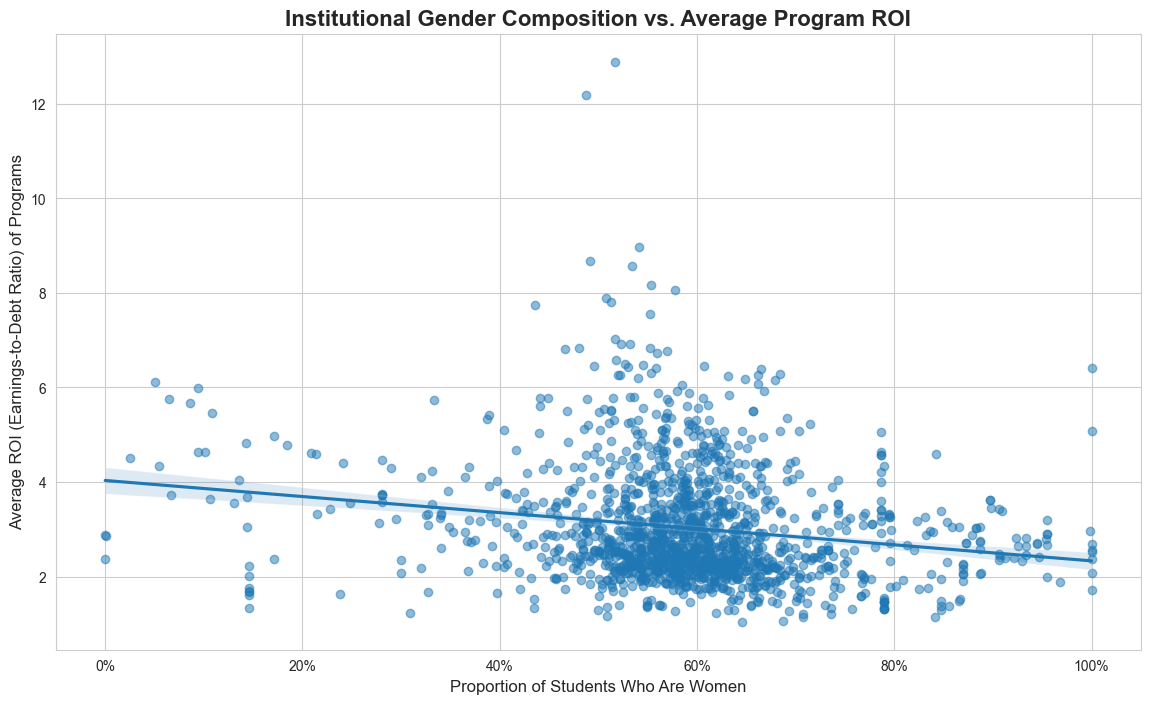


Step 3: Calculating the correlation
Correlation between Women Proportion and Average Institutional ROI: -0.1838


In [14]:
# Analyze the Relationship Between Gender Composition and Average ROI

# 1. Aggregate data to the institution level --
print("Step 1: Aggregating program-level data to the institution-level")

# Group by institution name ('INSTNM'), then calculate the mean ROI, the proportion of women, and the number of programs we have for each school.
df_school_summary = df_merged.groupby('INSTNM').agg(
    avg_roi=('ROI_EARNINGS_TO_DEBT', 'mean'),
    women_proportion=('UGDS_WOMEN', 'first'),      # 'first' is used because this value is the same for all programs in a school
    program_count=('INSTNM', 'size')              # 'size' counts the number of programs per school
).dropna()

# To make the "average ROI" meaningful, we'll only keep schools for which we have data on at least 5 programs.
df_school_summary = df_school_summary[df_school_summary['program_count'] >= 5]

print(f"Analysis will be based on {len(df_school_summary)} institutions with 5 or more programs in our dataset.")


# 2. Visualization: Scatter Plot with Regression Line
print("\nStep 2: Visualizing the relationship")
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Use seaborn's regplot function, which automatically creates a scatter plot and fits a regression line.
sns.regplot(
    data=df_school_summary,
    x='women_proportion',
    y='avg_roi',
    scatter_kws={'alpha':0.5} # Make the scatter points slightly transparent
)

plt.title('Institutional Gender Composition vs. Average Program ROI', fontsize=16, weight='bold')
plt.xlabel('Proportion of Students Who Are Women', fontsize=12)
plt.ylabel('Average ROI (Earnings-to-Debt Ratio) of Programs', fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x*100)}%'))

figure_path = figures_dir / 'notebook3' / 'gender_roi.png'
plt.savefig(figure_path, bbox_inches='tight')
plt.show()


# 3. Quantitative Analysis: Calculate the Correlation
print("\nStep 3: Calculating the correlation")
gender_roi_corr = df_school_summary['women_proportion'].corr(df_school_summary['avg_roi'])
print(f"Correlation between Women Proportion and Average Institutional ROI: {gender_roi_corr:.4f}")

4.2 Visualize the Relationship Between Gender Composition and Average Absolute Earnings by Institution Types.

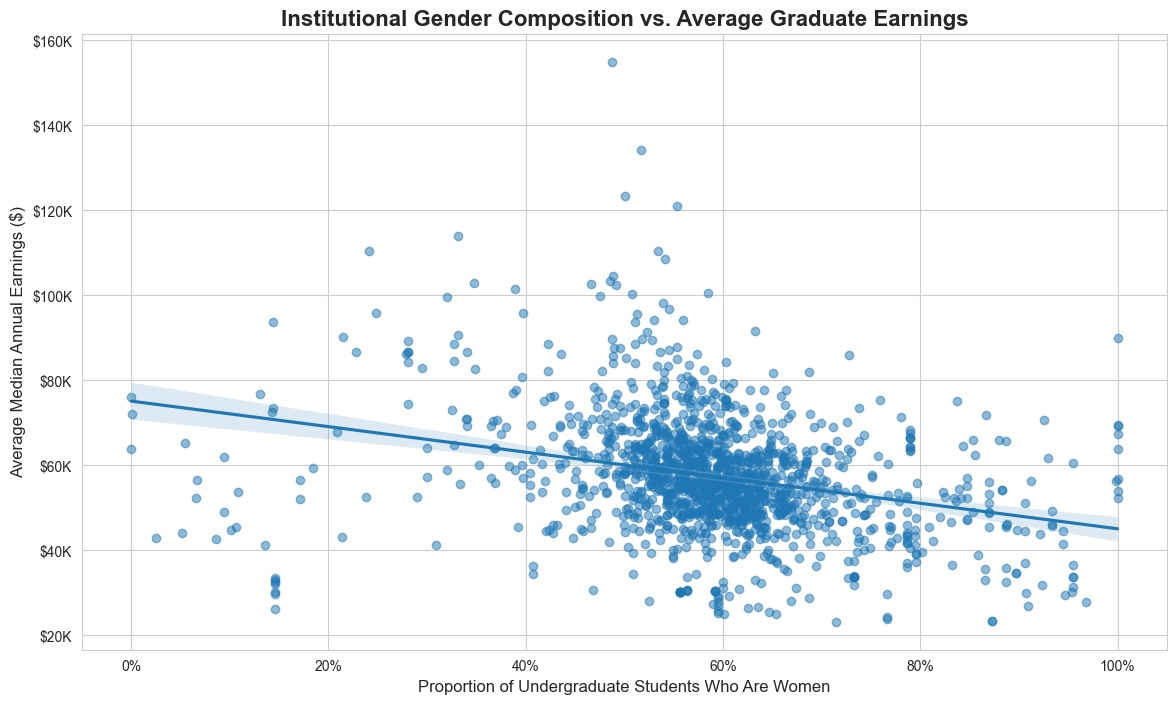

Correlation between Women Proportion and Average Institutional Earnings: -0.2894


In [15]:
# Gender Composition vs. Average Absolute Earnings

# 1. Re-aggregate the data, this time including average earnings
df_school_summary_extended = df_merged.groupby('INSTNM').agg(
    avg_roi=('ROI_EARNINGS_TO_DEBT', 'mean'),
    avg_earnings=('EARN_MDN_5YR', 'mean'),  
    women_proportion=('UGDS_WOMEN', 'first'),
    program_count=('INSTNM', 'size')
).dropna()

# Again, keep only schools with at least 5 programs.
df_school_summary_extended = df_school_summary_extended[df_school_summary_extended['program_count'] >= 5]

# 2. Visualization: Absolute Earnings vs Female Proportion
plt.figure(figsize=(14, 8))
sns.regplot(
    data=df_school_summary_extended,
    x='women_proportion',
    y='avg_earnings',  
    scatter_kws={'alpha':0.5}
)
plt.title('Institutional Gender Composition vs. Average Graduate Earnings', fontsize=16, weight='bold')
plt.xlabel('Proportion of Undergraduate Students Who Are Women', fontsize=12)
plt.ylabel('Average Median Annual Earnings ($)', fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x*100)}%'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'${int(y/1000):,}K'))

figure_path = figures_dir / 'notebook3' / 'gender_earnings.png'
plt.savefig(figure_path, bbox_inches='tight')
plt.show()

# 3. Quantitative Analysis: Calculate the Correlation
earnings_gender_corr = df_school_summary_extended['women_proportion'].corr(df_school_summary_extended['avg_earnings'])
print(f"Correlation between Women Proportion and Average Institutional Earnings: {earnings_gender_corr:.4f}")